<a href="https://colab.research.google.com/github/AlfiraAuliaMahrani/SNA-Girvan-Newman/blob/main/deteksi_komunitas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imported Libraries

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import warnings
import seaborn as sns


warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('Bismillah.csv')
df.head()

,source_user,target_user,relation_type,tweet_url
0,drtonychoppers,18autobase,reply,https://twitter.com/drtonychoppers/status/1200...
1,indurateiz,xnlyblind,reply,https://twitter.com/indurateiz/status/11998956...
2,iwishiwereshe,clrvltn,reply,https://twitter.com/iwishiwereshe/status/11986...
3,notalux,ardianpancaa,reply,https://twitter.com/notalux/status/11984522952...
4,la_capila76,kafiradikal,reply,https://twitter.com/la_capila76/status/1197384...


## Community Detection

In [ ]:
G = nx.Graph()

# Loop tiap baris relasi
for _, row in df.iterrows():
    user = row['source_user']
    target = row['target_user']
    relation = row['relation_type']

    # Hindari self-loop
    if user == target:
        continue

    # Hanya proses jika relasi adalah 'reply'
    if relation != 'reply':
        continue

    # Cek apakah edge sudah ada, kalau belum buat kosong
    if G.has_edge(user, target):
        edge_data = G[user][target]
    else:
        edge_data = {"reply": 0}

    # Tambah ke relasi reply
    edge_data["reply"] += 1

    # Tambahkan/Update edge dengan data
    G.add_edge(user, target, **edge_data)

# Ringkasan graf
print(f"Jumlah node: {G.number_of_nodes()}")
print(f"Jumlah edge: {G.number_of_edges()}")

# Tampilkan contoh edge pertama
print("\nContoh edge dengan atribut:")
print(list(G.edges(data=True))[0])


Jumlah node: 2170
Jumlah edge: 1403

Contoh edge dengan atribut:
('drtonychoppers', '18autobase', {'reply': 1})


### Membuat Graf awal


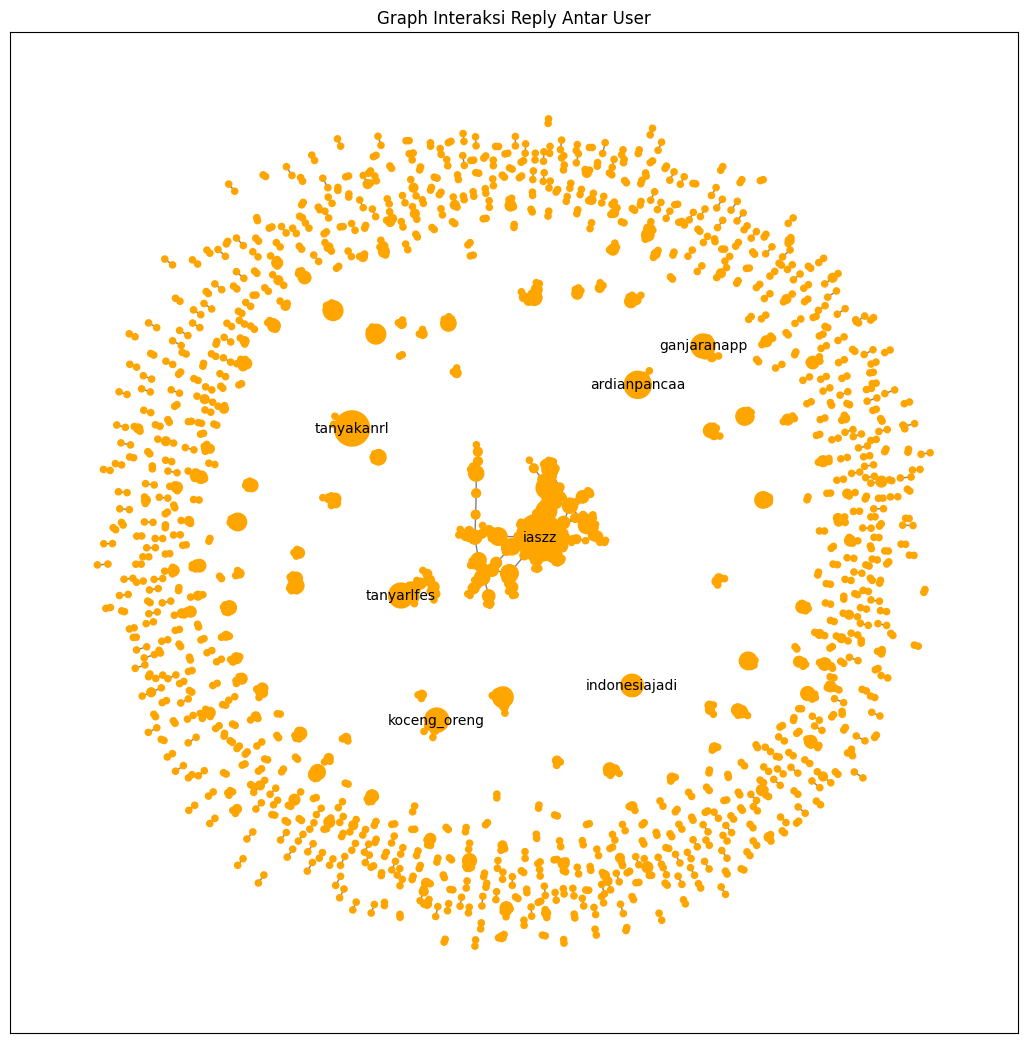

In [ ]:
def initial_graph(G):
    degree = dict(G.degree())
    top_nodes = sorted(degree, key=degree.get, reverse=True)[:7]

    plt.figure(figsize=(13, 13))

    pos = nx.spring_layout(G)

    # Buat edge berdasarkan hanya tipe interaksi reply
    edge_colors = []
    for u, v, data in G.edges(data=True):
        if data.get('reply', 0) > 0:
            edge_colors.append('grey')
        else:
            edge_colors.append('black')

    nx.draw_networkx(
        G,
        pos=pos,
        with_labels=True,
        labels={node: node if node in top_nodes else "" for node in G.nodes()},
        node_color='orange',
        edge_color=edge_colors,
        linewidths=1,
        font_size=10,
        node_size=[v * 20 for v in dict(G.degree()).values()]
    )
    plt.title("Graph Interaksi Reply Antar User")
    plt.show()


initial_graph(G)

### Filtered Connected Graph

graf yang telah disaring agar hanya menyisakan komponen yang terhubung

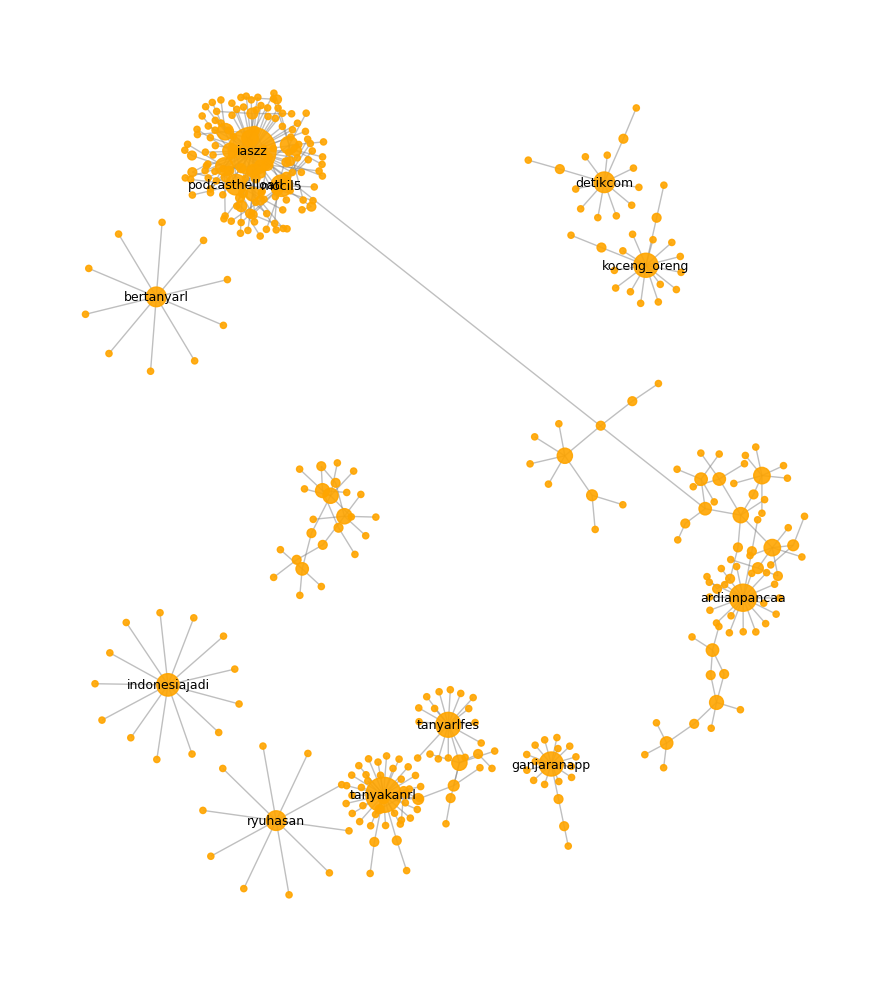

In [ ]:
def filtered_connected_graph(G, min_com):
    G_main = G.copy()

    # Deteksi komunitas
    communities_generator = nx.algorithms.community.girvan_newman(G_main)
    top_level_communities = next(communities_generator)

    # Filter komunitas besar
    filter_com = [c for c in top_level_communities if len(c) > min_com]
    nodes_to_keep = set(node for com in filter_com for node in com)
    G_main = G.subgraph(nodes_to_keep).copy()

    # Derajat & label
    degree = dict(G_main.degree())
    top_nodes = sorted(degree, key=degree.get, reverse=True)[:12]

    # Layout komunitas per spring, dengan posisi acak global
    pos = {}
    spacing =5 # jarak antar komunitas
    for community in filter_com:
        subgraph = G_main.subgraph(community)
        sub_pos = nx.spring_layout(subgraph, k=0.5, seed=random.randint(0, 10000))

        # Geser posisi komunitas ke tempat acak
        offset = np.random.uniform(-spacing, spacing, size=2)
        for node in sub_pos:
            pos[node] = sub_pos[node] + offset

    # Visualisasi
    plt.figure(figsize=(9,10))
    nx.draw_networkx_nodes(
        G_main, pos,
        node_color='orange',
        node_size=[degree[n]*20 for n in G_main.nodes()],
        alpha=0.9
    )
    nx.draw_networkx_edges(
        G_main, pos,
        edge_color='gray',
        alpha=0.5,
        width=1
    )
    nx.draw_networkx_labels(
        G_main, pos,
        labels={n: n for n in top_nodes},
        font_size=9
    )


    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return G_main

G_main = filtered_connected_graph(G, 10)


In [ ]:
print(str(G_main))

Graph with 397 nodes and 391 edges


### Running Girvan-Newman Algorithm

Algoritma Girvan-Newman digunakan untuk mendeteksi komunitas dalam graf dengan cara menghapus edge dengan betweenness centrality tertinggi secara bertahap.




In [ ]:
def girvan_newman(G):
    # Fungsi bantu untuk menentukan edge dengan nilai edge betweenness centrality tertinggi
    def most_valuable_edge(graph):
        centrality = nx.edge_betweenness_centrality(graph, weight='weight')
        return max(centrality, key=centrality.get)

    # Fungsi bantu untuk menghapus edge-edge paling sentral sampai jumlah komponen bertambah
    def without_most_central_edges(graph, most_valuable_edge_func):
        original_num_components = nx.number_connected_components(graph)
        num_new_components = original_num_components

        # Ulangi penghapusan edge paling sentral sampai jumlah komponen bertambah
        while num_new_components <= original_num_components:
            edge = most_valuable_edge_func(graph)
            graph.remove_edge(*edge)
            new_components = tuple(nx.connected_components(graph))  # Hitung ulang komponen
            num_new_components = len(new_components)
        return new_components

    # Jika graf tidak memiliki edge, langsung kembalikan komponen yang ada
    if G.number_of_edges() == 0:
        return tuple(nx.connected_components(G))


    g = G.copy().to_undirected()

    # Hapus self-loop karena tidak relevan untuk komputasi komunitas
    g.remove_edges_from(nx.selfloop_edges(g))


    community = []
    modularities = []
    i = 0
    while g.number_of_edges() > 0:
        communities = without_most_central_edges(g, most_valuable_edge)
        modularity = nx.algorithms.community.modularity(G, communities)  # Hitung nilai modularitas komunitas saat ini

        community.append(communities)
        modularities.append(modularity)


        print(f"Count of Community: {len(communities)}, Modularity: {modularity}")

        i += 1

        # Hentikan jika dalam 10 iterasi terakhir, tidak ada peningkatan modularitas signifikan
        if len(modularities) > 10 and all(modularities[-i] < modularities[-10] for i in range(2, 10)):
            break

    return community, modularities


community, modularity = girvan_newman(G_main)


Count of Community: 14, Modularity: 0.8252137283246446
Count of Community: 15, Modularity: 0.8600643637862126
Count of Community: 16, Modularity: 0.8781895722817092
Count of Community: 17, Modularity: 0.889191593461581
Count of Community: 18, Modularity: 0.8935642754822376
Count of Community: 19, Modularity: 0.8964750361392192
Count of Community: 20, Modularity: 0.8970604587882077
Count of Community: 21, Modularity: 0.8979369575028944
Count of Community: 22, Modularity: 0.8977832431760651
Count of Community: 23, Modularity: 0.8975477659094326
Count of Community: 24, Modularity: 0.8972305257029976
Count of Community: 25, Modularity: 0.8968315225567598
Count of Community: 26, Modularity: 0.8960760329929813
Count of Community: 27, Modularity: 0.8955592912134274
Count of Community: 28, Modularity: 0.8947187681922539
Count of Community: 29, Modularity: 0.8932110595822893
Count of Community: 30, Modularity: 0.8916739163139957


### Visualize Differential Value of Modularity

Visualisasi Perbedaan Nilai Modularitas dalam Algoritma Girvan-Newman

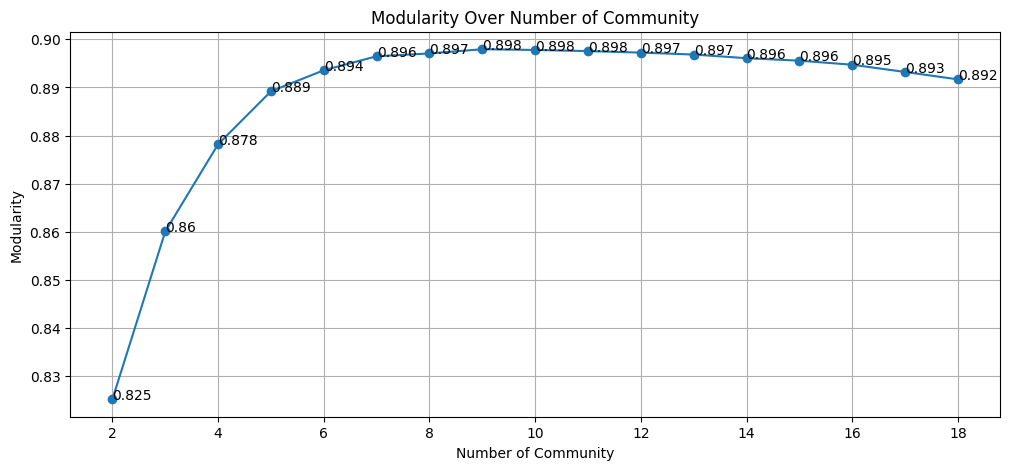

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(range(2, len(modularity) + 2), modularity, marker='o')

# Menambahkan anotasi nilai modularity di setiap titik
for i, txt in enumerate(modularity):
    plt.annotate(round(txt, 3), (i + 2, modularity[i]))  # Anotasi dengan pembulatan 3 desimal di posisi (x, y)
plt.xlabel("Number of Community")
plt.ylabel("Modularity")
plt.title("Modularity Over Number of Community")
plt.grid()
plt.show()

### Visualize Final Graph

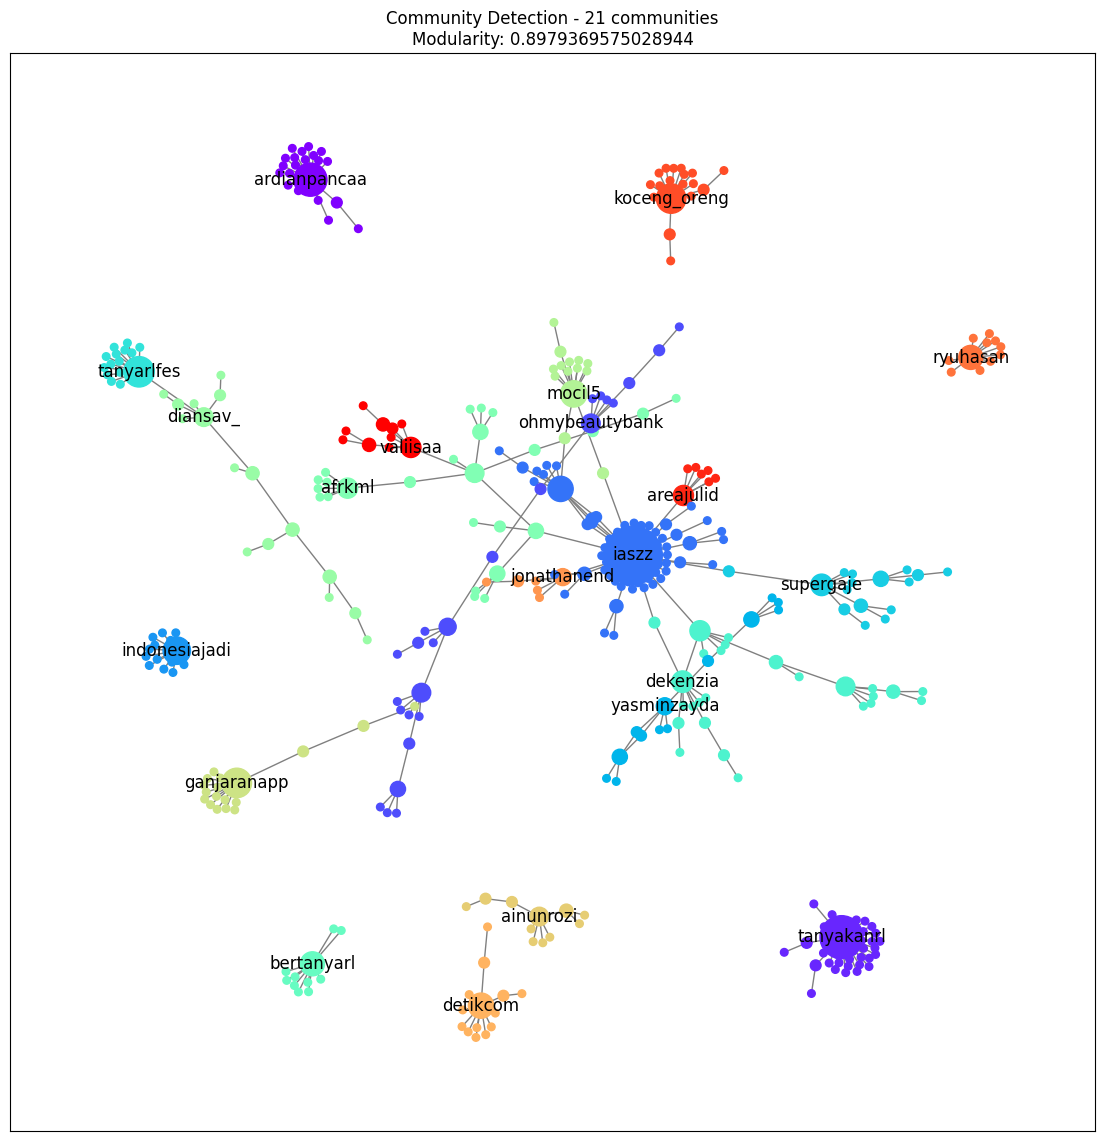

In [ ]:
def visualize_gn(G, target_com):
    # Buat generator komunitas dengan algoritma Girvan-Newman
    communities_generator = nx.algorithms.community.centrality.girvan_newman(G)

    target_num_communities = target_com

    node_groups = []
    color_map = []
    centers = {}
    labels = {}

    # Lewati beberapa iterasi untuk mencapai jumlah komunitas target
    for i in range(target_num_communities):
        next(communities_generator)

    # Ambil komunitas pada iterasi berikutnya dan simpan sebagai list
    for com in next(communities_generator):
        node_groups.append(list(com))

    # Tentukan warna tiap node berdasarkan komunitas tempatnya berada
    for node in G:
        for i in range(len(node_groups)):
            if node in node_groups[i]:
                color_map.append(i)

    for i, com in enumerate(node_groups):
        center = max(com, key=G.degree)
        centers[center] = node_groups[i]
        labels[center] = center

    plt.figure(figsize=(14, 14))
    nx.draw_networkx(
        G,
        labels=labels,
        with_labels=True,
        node_color=color_map,
        cmap=plt.cm.rainbow,
        edge_color='grey',
        linewidths=1,
        font_size=12,
        node_size=[v * 30 for v in dict(G.degree()).values()],
        pos=nx.fruchterman_reingold_layout(G)
    )

    plt.title(f"Community Detection - {len(node_groups)} communities\nModularity: {nx.algorithms.community.modularity(G, node_groups)}")
    plt.show()

    return centers

max_index_mod = modularity.index(max(modularity))
centers = visualize_gn(G_main, max_index_mod)

In [ ]:
from tabulate import tabulate

# Buat DataFrame komunitas
df_komunitas = pd.DataFrame({
    'Center': list(centers.keys()),
    'Community': list(centers.values())
})

# Hitung jumlah anggota
df_komunitas['Jumlah Anggota'] = df_komunitas['Community'].apply(len)

# Gabungkan nama-nama anggota dalam 1 string
df_komunitas['Anggota'] = df_komunitas['Community'].apply(lambda x: ', '.join(x))

# Hapus kolom Community asli
df_komunitas = df_komunitas.drop(columns=['Community'])

# Cetak dengan tabulate
print(tabulate(df_komunitas, headers='keys', tablefmt='pretty', showindex=False))


+----------------+----------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|     Center     | Jumlah Anggota |                                                 

In [ ]:
# Simpan graf hasil komunitas ke file GEXF agar bisa dibuka di Gephi
nx.write_gexf(G_main, "Girvan.gexf")
print("Graf telah diekspor sebagai 'community_graph.gexf'.")


Graf telah diekspor sebagai 'community_graph.gexf'.
